###  Import Libraries

This section imports essential libraries for model building (`torch`, `torch.nn`), data loading (`torchvision`, `DataLoader`), pretrained models (`timm`), training visualization (`tqdm`), plotting (`matplotlib`), and model interpretability using Grad-CAM.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

### Configuration Settings
defines key training configurations. It sets the device to GPU if available, otherwise CPU. It also specifies the batch size, number of training epochs, and learning rates for different models (`swin_lr` for Swin Transformer and `vit_lr` for ViT). Finally, it defines the number of output classes (`num_classes`), which is 10 in this case.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 50
swin_lr = 5e-4
vit_lr = 0.001
num_classes = 10

### Data Transformations
defines the data preprocessing steps using `transforms.Compose`. Both training and test images are resized from CIFAR-10's original size (32×32) to 224×224 to match the input size required by transformer-based models like ViT and Swin. The training transform includes random horizontal flipping for data augmentation. Both transforms convert images to tensors and normalize them to have values in the range [-1, 1].

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Load CIFAR-10 Dataset
This section loads the CIFAR-10 dataset using the defined transformations. The training and test sets are downloaded and wrapped in `DataLoader` objects for efficient batch processing. Shuffling is enabled for training to improve generalization, while it's disabled for testing. `num_workers=4` allows parallel data loading.


In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Load Swin Transformer Model

This line loads a pre-trained Swin Transformer (`swin_base_patch4_window7_224`) from the `timm` library. Using a pre-trained model allows for transfer learning, which can speed up training and improve performance.


In [ ]:
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

### Custom Classification Head
defines a custom head (`SwinHead`) for the Swin Transformer. It applies global average pooling to reduce spatial dimensions, then passes the features through a normalization layer, a linear layer, ReLU activation, dropout for regularization, and a final linear layer to output predictions for `num_classes`. The original classification head of the pre-trained Swin model is replaced with this custom head.


In [ ]:
class SwinHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(SwinHead, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Reduce [batch, C, H, W] to [batch, C, 1, 1]
        self.fc = nn.Sequential(
                    nn.LayerNorm(in_features),
                    nn.Linear(in_features, 512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512, num_classes)
                )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.global_pool(x)  # Shape: [batch, C, 1, 1]
        x = x.flatten(1)  # Shape: [batch, C]

        x = self.fc(x)  # Shape: [batch, num_classes]
        return x 

swin_model.head = SwinHead(swin_model.head.in_features, num_classes)

### Load Vision Transformer (ViT) Model
loads a pre-trained Vision Transformer model (`vit_base_patch16_224`) from the `timm` library. Pre-trained weights enable transfer learning for improved performance on the CIFAR-10 dataset.


In [ ]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

### Modify ViT Classification Head
This line replaces the ViT model's original classification head with a new linear layer that outputs predictions for 10 classes, matching the CIFAR-10 dataset.


In [ ]:
vit_model.head = nn.Linear(vit_model.head.in_features, 10)

### Move Models to Device
moves both the Swin Transformer and Vision Transformer models to the selected device (GPU if available, otherwise CPU) to enable efficient computation during training and inference.


In [ ]:
swin_model = swin_model.to(device)
vit_model = vit_model.to(device)

### Loss Function and Optimizers
defines the loss function as cross-entropy loss, suitable for multi-class classification. It also sets up AdamW optimizers for both Swin and ViT models with their respective learning rates to update model weights during training.


In [ ]:
criterion = nn.CrossEntropyLoss()
swin_optimizer = optim.AdamW(swin_model.parameters(), lr=swin_lr)
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=vit_lr)

### Training and Evaluation Functions

The `train` function runs one epoch of training: it sets the model to training mode, processes batches from the data loader, computes the loss, backpropagates errors, and updates model weights. It also tracks running loss and accuracy.

The `evaluate` function sets the model to evaluation mode, disables gradient calculation for efficiency, and computes loss and accuracy on the validation or test dataset without updating weights.

Both functions return the average loss and accuracy for the epoch.

In [ ]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        if labels.dim() > 1:
                labels = labels.squeeze()
        if labels.dim() == 0:
            labels = labels.unsqueeze(0)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs.data, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

### Train and Validate ViT Model
This block performs model training and validation for the specified number of epochs. It records training loss and accuracy as well as validation loss and accuracy after each epoch. The results are then plotted: training loss on the left y-axis and validation accuracy on the right y-axis, helping visualize model performance trends over time.


Epoch 01: Train Loss = 2.285, Val Accuracy = 25.82%
Epoch 02: Train Loss = 2.097, Val Accuracy = 30.06%
Epoch 03: Train Loss = 1.989, Val Accuracy = 32.85%
Epoch 04: Train Loss = 1.856, Val Accuracy = 35.47%
Epoch 05: Train Loss = 1.690, Val Accuracy = 37.39%
Epoch 06: Train Loss = 1.646, Val Accuracy = 39.68%
Epoch 07: Train Loss = 1.404, Val Accuracy = 41.62%
Epoch 08: Train Loss = 1.340, Val Accuracy = 44.64%
Epoch 09: Train Loss = 1.237, Val Accuracy = 45.97%
Epoch 10: Train Loss = 1.219, Val Accuracy = 47.65%
Epoch 11: Train Loss = 1.169, Val Accuracy = 48.09%
Epoch 12: Train Loss = 1.091, Val Accuracy = 50.67%
Epoch 13: Train Loss = 1.141, Val Accuracy = 51.62%
Epoch 14: Train Loss = 1.010, Val Accuracy = 51.79%
Epoch 15: Train Loss = 0.955, Val Accuracy = 52.68%
Epoch 16: Train Loss = 0.965, Val Accuracy = 53.52%
Epoch 17: Train Loss = 0.858, Val Accuracy = 54.46%
Epoch 18: Train Loss = 0.947, Val Accuracy = 55.46%
Epoch 19: Train Loss = 0.788, Val Accuracy = 55.95%
Epoch 20: Tr

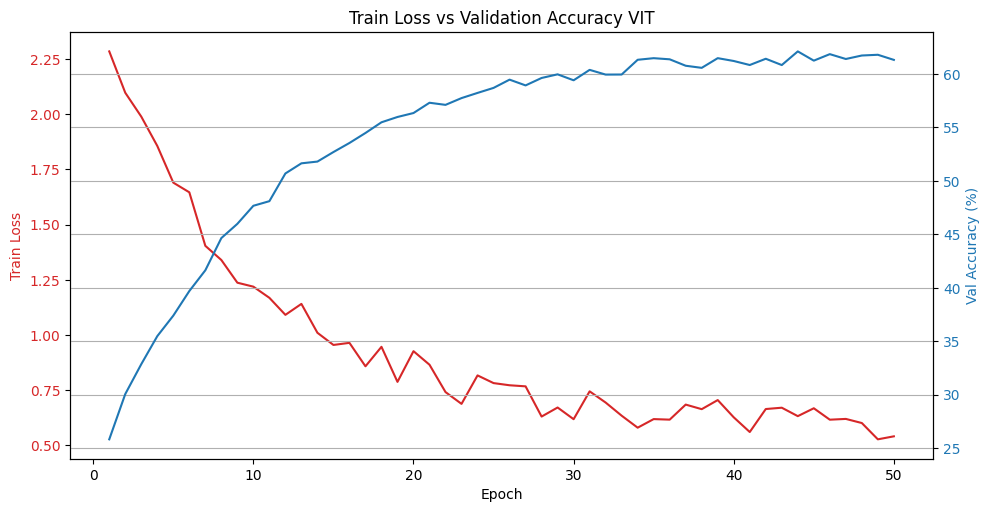

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(vit_model, train_loader, criterion, vit_optimizer)
    val_loss, val_acc = evaluate(vit_model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

import numpy as np
fig, ax1 = plt.subplots(figsize=(10, 5))
epoch_arr = np.arange(1, epochs + 1)

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(epoch_arr, train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Val Accuracy (%)', color=color)
ax2.plot(epoch_arr, val_accuracies, color=color, label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Train Loss vs Validation Accuracy VIT")
plt.grid(True)
plt.show()


### Train and Validate SWIN Model
This block performs model training and validation for the specified number of epochs. It records training loss and accuracy as well as validation loss and accuracy after each epoch. The results are then plotted: training loss on the left y-axis and validation accuracy on the right y-axis, helping visualize model performance trends over time.


Epoch 01: Train Loss = 2.047, Val Accuracy = 29.87%
Epoch 02: Train Loss = 1.875, Val Accuracy = 34.07%
Epoch 03: Train Loss = 1.754, Val Accuracy = 37.12%
Epoch 04: Train Loss = 1.625, Val Accuracy = 39.95%
Epoch 05: Train Loss = 1.482, Val Accuracy = 42.18%
Epoch 06: Train Loss = 1.413, Val Accuracy = 44.61%
Epoch 07: Train Loss = 1.237, Val Accuracy = 46.70%
Epoch 08: Train Loss = 1.164, Val Accuracy = 49.50%
Epoch 09: Train Loss = 1.073, Val Accuracy = 51.03%
Epoch 10: Train Loss = 1.033, Val Accuracy = 52.76%
Epoch 11: Train Loss = 0.977, Val Accuracy = 53.54%
Epoch 12: Train Loss = 0.910, Val Accuracy = 55.82%
Epoch 13: Train Loss = 0.915, Val Accuracy = 56.89%
Epoch 14: Train Loss = 0.822, Val Accuracy = 57.36%
Epoch 15: Train Loss = 0.773, Val Accuracy = 58.31%
Epoch 16: Train Loss = 0.761, Val Accuracy = 59.20%
Epoch 17: Train Loss = 0.687, Val Accuracy = 60.13%
Epoch 18: Train Loss = 0.723, Val Accuracy = 61.08%
Epoch 19: Train Loss = 0.622, Val Accuracy = 61.65%
Epoch 20: Tr

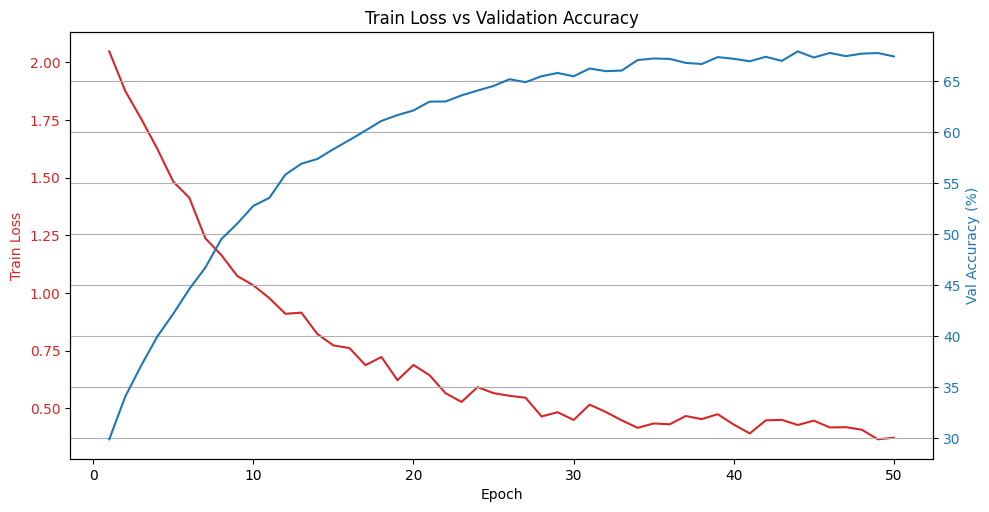

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(swin_model, train_loader, criterion, swin_optimizer)
    val_loss, val_acc = evaluate(swin_model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


import numpy as np
fig, ax1 = plt.subplots(figsize=(10, 5))
epoch_arr = np.arange(1, epochs + 1)

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(epoch_arr, train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Val Accuracy (%)', color=color)
ax2.plot(epoch_arr, val_accuracies, color=color, label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Train Loss vs Validation Accuracy")
plt.grid(True)
plt.show()


### Grad-CAM Visualization for Swin Transformer
extracts a batch from the test set and selects one image to visualize. It sets up Grad-CAM using the last normalization layer of the final Swin Transformer block as the target. The Grad-CAM heatmap highlights regions in the image that most influenced the model’s prediction for the true label. Finally, it displays the original image alongside the Grad-CAM overlay for interpretability.


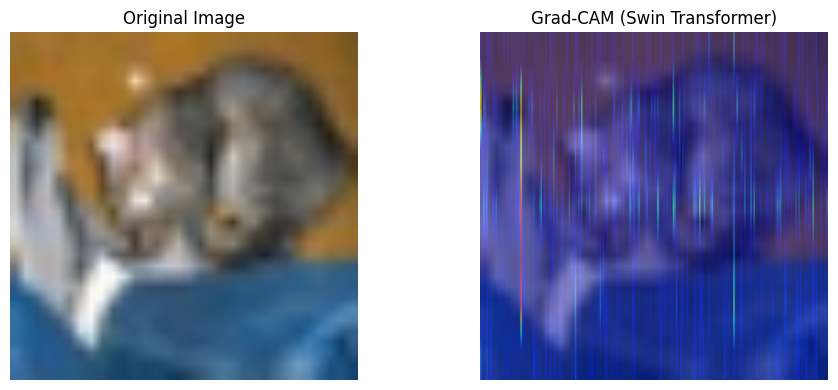

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()

target_layers = [swin_model.layers[-1].blocks[-1].norm1]  # Swin-specific

cam = GradCAM(model=swin_model, target_layers=target_layers)
targets = [ClassifierOutputTarget(label)]

grayscale_cam = cam(input_tensor=image, targets=targets)[0]  # First image

rgb_img = image[0].cpu().numpy().transpose(1, 2, 0)
rgb_img = (rgb_img * 0.5) + 0.5
rgb_img = rgb_img.clip(0, 1)

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(rgb_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (Swin Transformer)")
plt.imshow(cam_image)
plt.axis('off')

plt.tight_layout()
plt.show()

### Grad-CAM with Reshape Transform for Swin Transformer Attention
visualizes Grad-CAM on the Swin Transformer's attention layer. Because attention outputs are sequence tensors, a custom `reshape_transform` reshapes them into spatial feature maps suitable for Grad-CAM. The heatmap highlights important image regions influencing the model’s prediction. The original and Grad-CAM overlay images are displayed side-by-side for interpretation.

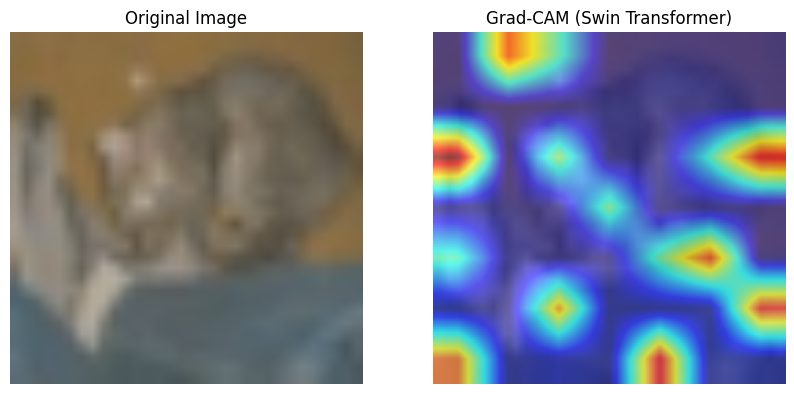

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()

target_layer = swin_model.layers[-1].blocks[-1].attn

def reshape_transform(tensor):
    B, N, C = tensor.size()
    h = w = int(N ** 0.5)
    tensor = tensor.permute(0, 2, 1).contiguous()  # [B, C, N]
    tensor = tensor.reshape(B, C, h, w)
    return tensor

cam = GradCAM(model=swin_model, target_layers=[target_layer], reshape_transform=reshape_transform)
targets = [ClassifierOutputTarget(labels[0].item())]

grayscale_cam = cam(input_tensor=images, targets=targets)[0]  # shape [H, W]

img_np = images[0].cpu().permute(1, 2, 0).numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = img_np.clip(0, 1)

cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (Swin Transformer)")
plt.imshow(cam_image)
plt.axis('off')
plt.show()


### Grad-CAM Visualization for Vision Transformer (ViT)
applies Grad-CAM to the last normalization layer of the ViT model. Since ViT uses a CLS token and flattened patches, a custom `reshape_transform` removes the CLS token and reshapes the feature map back into spatial dimensions for visualization. The original image and Grad-CAM heatmap are displayed side-by-side to interpret the model’s focus areas.


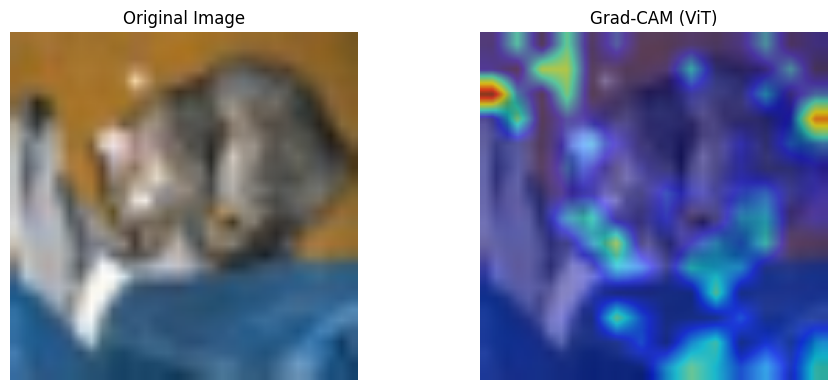

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()

target_layers = vit_model.blocks[-1].norm1

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :]  # Remove CLS token
    result = result.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)  # [B, D, H, W]
    return result

cam = GradCAM(model=vit_model, target_layers=[target_layers], reshape_transform=reshape_transform)
targets = [ClassifierOutputTarget(label)]

grayscale_cam = cam(input_tensor=image, targets=targets)[0]

rgb_img = image[0].cpu().numpy().transpose(1, 2, 0)
rgb_img = (rgb_img * 0.5) + 0.5
rgb_img = rgb_img.clip(0, 1)

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(rgb_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (ViT)")
plt.imshow(cam_image)
plt.axis('off')

plt.tight_layout()
plt.show()